<a href="https://colab.research.google.com/github/Tiabet/DACON_WebClick/blob/main/WebClick_EDA%2BPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import plotly.express as px
import lightgbm as lgb
# import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

In [ ]:
# 동일한 결과 보장을 위해 Seed값을 고정합니다
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed를 42로 고정

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/data/train.parquet')
test = pd.read_parquet('/content/drive/MyDrive/data/test.parquet')

In [ ]:
train = train.groupby('Click').apply(lambda x: x.sample(min(len(x), 5569860)))

In [ ]:
#EDA 2 : Imbalance
click = train['Click'].value_counts(normalize=True)

click_figure = px.bar(click,
             x=['Not Clicked : 0', 'Clicked : 1'],
             y=click.values.tolist(),
             labels={'x': 'Value', 'y': 'Percentage'},
             width = 450,
             height = 500
            )

# 그래프 표시
click_figure.show()

In [ ]:
#Data Preprocessing 1 : Select x, y
train_x = train.drop(columns=['ID', 'Click'])
train_y = train['Click']

test_x = test.drop(columns=['ID'])

Simple EDA

In [ ]:
# Calculate the percentage of null values in each column
null_percentage = (train_x.isnull().sum() / len(train_x)) * 100

# Print the percentage of null values for each column
print(null_percentage)

F01     4.273070
F02     4.273070
F03    38.584219
F04    22.174848
F05     4.273070
F06     0.000000
F07     0.000000
F08     0.000000
F09     0.000000
F10     4.273070
F11    10.672629
F12     4.273070
F13     0.000000
F14     0.000000
F15    38.584219
F16     0.000000
F17     0.000000
F18    26.863898
F19     9.584559
F20    38.584219
F21     0.000000
F22     0.000000
F23     0.000000
F24    27.320453
F25     0.000000
F26    38.584219
F27    35.636120
F28     0.000000
F29    35.636120
F30     0.000000
F31     0.000000
F32     0.703267
F33     9.584559
F34     4.273070
F35     0.000000
F36    26.863898
F37     0.000000
F38     2.831059
F39     0.000000
dtype: float64


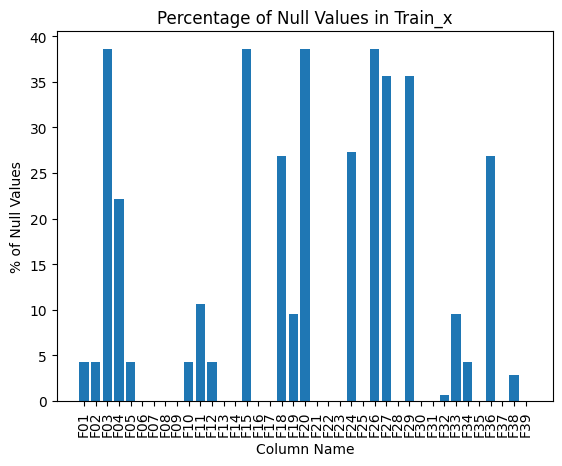

In [ ]:
# Create a bar chart
plt.bar(train_x.columns, null_percentage)

# Add labels and title
plt.xlabel("Column Name")
plt.ylabel("% of Null Values")
plt.title("Percentage of Null Values in Train_x")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [ ]:
# Get the value counts for each column, excluding NaN values
# value_counts = train_x.apply(lambda col: col.value_counts(dropna=False))

# Print the value counts for each column
# print(value_counts)

# value_counts = pd.DataFrame(value_counts)


Data Preprocessing

In [ ]:
# Function to fill NaN with the most common value for each column
def fill_na_with_mode(df):
    for column in df.columns:
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)
    return df

# Apply the function
train_x = fill_na_with_mode(train_x)
test_x = fill_na_with_mode(test_x)
train_x.isnull().sum()

In [ ]:
#Data Preprocessing 2 : Fill NaN
# for col in tqdm(train_x.columns):
#     if train_x[col].isnull().sum() != 0:
#         train_x[col].fillna(0, inplace=True)
#         test_x[col].fillna(0, inplace=True)

100%|██████████| 39/39 [00:25<00:00,  1.50it/s]


In [ ]:
#Data Preprocessing 3 : Count Encoding
# encoding_target = list(train_x.dtypes[train_x.dtypes == "object"].index)

# enc = ce.CountEncoder(cols = encoding_target).fit(train_x, train_y)
# X_train_encoded = enc.transform(train_x)
# X_test_encoded = enc.transform(test_x)

In [ ]:
# Label encode categorical columns
def label_encode_columns(train_df, test_df):
    le = LabelEncoder()
    for column in train_df.columns:
        if train_df[column].dtype == 'object' or isinstance(train_df[column].dtype, pd.CategoricalDtype):
            # Fit the LabelEncoder on the combined data to ensure consistency
            combined_data = pd.concat([train_df[column], test_df[column]], axis=0).astype(str)
            le.fit(combined_data)
            train_df[column] = le.transform(train_df[column].astype(str))
            test_df[column] = le.transform(test_df[column].astype(str))
    return train_df, test_df

# Apply label encoding to train_x and test_x
train_x, test_x = label_encode_columns(train_x, test_x)

In [ ]:
# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

In [ ]:
# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': ['binary_logloss', 'auc'],
    'num_leaves': 31,  # Increased num_leaves
    'learning_rate': 0.02,  # Reduced learning rate
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_bin': 300,  # Increased max_bin
    'min_child_samples': 20,  # Increased min_child_samples
    'reg_alpha': 0.02,  # Increased regularization alpha
    'reg_lambda': 0.03,  # Increased regularization lambda
    'verbose': -1,
    'n_estimators': 200  # Increased n_estimators
}

# Train the model
num_round = 2000
bst = lgb.train(params, train_data, num_round, valid_sets=[valid_data],callbacks=[lgb.early_stopping(stopping_rounds=10)],)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.616531	valid_0's auc: 0.722004


In [ ]:
# Predict on the test set
y_pred_test = bst.predict(test_x, num_iteration=bst.best_iteration)

In [ ]:
sample_submission = pd.read_csv('drive/MyDrive/data/sample_submission.csv')

In [ ]:
sample_submission['Click'] = y_pred_test
sample_submission

,ID,Click
0,TEST_0000000,0.620276
1,TEST_0000001,0.437564
2,TEST_0000002,0.504862
3,TEST_0000003,0.605403
4,TEST_0000004,0.751874
...,...,...
4538536,TEST_4538536,0.411110
4538537,TEST_4538537,0.628984
4538538,TEST_4538538,0.327492
4538539,TEST_4538539,0.449894


In [ ]:
sample_submission.to_csv("drive/MyDrive/data/lgbm_prediction.csv",index = False)

In [ ]:
train_x.to_parquet('drive/MyDrive/data/train_preprocessed.parquet', compression = 'gzip', engine = 'pyarrow', index = False)
test_x.to_parquet('drive/MyDrive/data/test_preprocessed.parquet', compression = 'gzip', engine = 'pyarrow', index = False)